## Bert multi-class

In [68]:
!pip install transformers

In [69]:
import transformers
import torch
import pandas as pd
from tqdm.notebook import tqdm
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils import data
import numpy as np
from transformers import AdamW # optimizer
from transformers import get_linear_schedule_with_warmup # for learning rate
from transformers import BertModel
import torch.nn.functional as F

In [70]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [71]:
dataset = pd.read_csv("sample_data/new_label_dataset.csv")[['content', 'priority']]
testset = pd.read_csv("sample_data/new_label_testset.csv")[['content', 'priority']]
dataset = dataset[dataset['priority'] != 'Unknown'].reset_index(drop=True)
testset = testset[testset['priority'] != 'Unknown'].reset_index(drop=True)

print("size of train set: ", len(dataset))
print("size of test set: ", len(testset))

for i in tqdm(range(len(dataset))):
    if dataset.loc[i, 'priority'] == 'Critical': dataset.loc[i, 'priority'] = 0
    elif dataset.loc[i, 'priority'] == 'High': dataset.loc[i, 'priority'] = 1
    elif dataset.loc[i, 'priority'] == 'Medium': dataset.loc[i, 'priority'] = 2
    elif dataset.loc[i, 'priority'] == 'Low': dataset.loc[i, 'priority'] = 3
    else:
        pass

for i in tqdm(range(len(testset))):
    if testset.loc[i, 'priority'] == 'Critical': testset.loc[i, 'priority'] = 0
    elif testset.loc[i, 'priority'] == 'High': testset.loc[i, 'priority'] = 1
    elif testset.loc[i, 'priority'] == 'Medium': testset.loc[i, 'priority'] = 2
    elif testset.loc[i, 'priority'] == 'Low': testset.loc[i, 'priority'] = 3
    else:
        pass 

size of train set:  29113
size of test set:  8179


In [72]:
dataset[:3]

,content,priority
0,philippine flood worsen death toll hit wake ge...,3
1,philippine flood fatality hit,3
2,luzon dam release water flood warn up manila p...,3


In [73]:
weight = torch.tensor([len(dataset[dataset['priority']==0])/42726, len(dataset[dataset['priority']==1])/42726, len(dataset[dataset['priority']==2])/42726, len(dataset[dataset['priority']==3])/42726])

weight

tensor([0.0072, 0.0822, 0.1255, 0.4665])

In [74]:
class GPRreviewDataset(data.Dataset):
    def __init__(self, content, target, tokenizer, max_len):
        self.content = content
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.content)
    
    def __getitem__(self, item):
        content = str(self.content[item])
        encoding = tokenizer.encode_plus(
            content,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': content,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [75]:
MAX_LEN = 30
BATCH_SIZE = 32

df_train, df_test = dataset, testset

In [76]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPRreviewDataset(
        content = df.content.to_numpy(),
        target = df.priority.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len,
    )
    return data.DataLoader(
        ds, 
        batch_size = batch_size,
    )

In [77]:
train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [78]:
from transformers import BertForSequenceClassification


# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 4,  
    output_attentions = False,
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

device = 'cuda'
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [79]:
def train(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = 0
    correct_predictions = 0
    for d in data_loader:
        optimizer.zero_grad()
        
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        loss, logits = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=targets)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses+=loss.item()
    return losses/len(data_loader)

In [80]:
def val(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = 0
    targets_list, prob_list = [], []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            loss, logits = model(input_ids, token_type_ids=None, attention_mask=attention_mask,labels=targets)
            
            logits = logits.detach().cpu()
            prob = F.softmax(logits, dim=1).numpy()

            losses+=loss.item()
            targets_list.append(targets)
            prob_list.append(prob)
    return losses/len(data_loader), targets_list, prob_list

In [81]:
EPOCHS = 30
train_loss_list, val_loss_list = [], []

total_steps = len(train_loader) * EPOCHS
optimizer = AdamW(model.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

for epoch in tqdm(range(EPOCHS)):
    train_loss = train(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    val_loss, targets_list, prob_list = val(
        model,
        test_loader,
        loss_fn,
        device,
        len(df_test)
    )

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print("train loss: ", train_loss, "val loss:", val_loss)

    # if len(val_loss_list) >= 2:
    #     if val_loss_list[-2] - val_loss_list[-1] < 0.01:
    #         break

train loss:  0.7705374629042305 val loss: 0.47217112967337016
train loss:  0.7633861502161721 val loss: 0.47709171642782167
train loss:  0.7070192237640475 val loss: 0.5152837299829116
train loss:  0.6829728672014815 val loss: 0.5380142947979039
train loss:  0.6742230783083609 val loss: 0.5364078381535364
train loss:  0.6048035125319774 val loss: 0.5876604471122846
train loss:  0.5392538697018728 val loss: 0.5675879717455246
train loss:  0.4989341038555562 val loss: 0.6559780559473438
train loss:  0.47074787093142234 val loss: 0.7190113053366076
train loss:  0.4306738769860713 val loss: 0.7508641191816423
train loss:  0.410749101503701 val loss: 0.7522167621646076
train loss:  0.38447188904693164 val loss: 0.7826754457055358
train loss:  0.3636226848985713 val loss: 0.8156945925002219
train loss:  0.3368251916021109 val loss: 0.8882574426970677
train loss:  0.3181829325517046 val loss: 0.9046175761322957
train loss:  0.298800618689671 val loss: 0.8941515682963654
train loss:  0.2771606

### Result:

In [82]:

score = 0

for i in range(len(targets_list)):
    index_list = targets_list[i]
    for j, index in enumerate(index_list):
    key = index.item()
    if key == 0: weight = 1
    elif key == 1: weight = 0.75
    elif key == 2: weight = 0.5
    elif key == 3: weight = 0.25
    else: weight = 0

    score += (weight - weight * prob_list[i][j][key].item())**2

score /= len(testset)

print("RMSE all: ", score)

RMSE all:  0.05327899082140905


Text(0.5, 1.0, 'train and test loss')

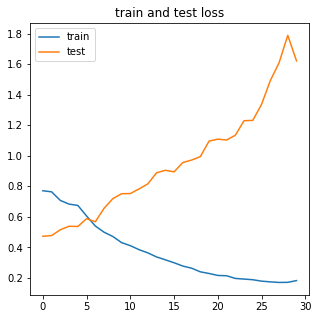

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([i for i in range(len(train_loss_list))], train_loss_list, label='train')
plt.plot([i for i in range(len(train_loss_list))], val_loss_list, label='test')
plt.legend()
plt.title("train and test loss")

* BERT Fine-Tuning Tutorial with PyTorch: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

* BERT and Transformers by Hugging Face: https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/